# Regression Trees and Model Optimization - Lab

## Introduction

In this final lab, we shall see how to apply regression analysis using CART trees for regression, with some hyper parameter tuning as we saw in the case of classification. For a comparison of predictive capabilities and computational cost, we shall work the "Boston Housing" dataset. This will allow us to compare different regression approaches in terms of their accuracy and cost involved. 

## Objectives
You will be able to:
- Apply predictive regression analysis with CART trees
- Get the data ready for modeling
- Tune the key hyper parameters based a various models developed during training 
- Study the impact of tree pruning on the quality of predictions

## Boston Housing Dataset - Again ! 

The dataset is available in the repo as `boston.csv`. 

- Load the Dataset and print its head and dimensions

In [42]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
plt.style.use('ggplot')
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.linear_model import LinearRegression

In [6]:
df = pd.read_csv('boston.csv')
print(f"Boston housing data has {df.shape[0]} data points with {df.shape[1]} variables each.")
df.head()

Boston housing data has 506 data points with 15 variables each.


,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Identify Features and Target Data
In this lab, we shall use three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point:

#### Features
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

#### Target
- `MEDV`' has been multiplicatively scaled to account for 35 years of market inflation.


- Create dataframes for features and target as shown above. 
- Inspect the contents for validity 

In [9]:
X = df[['rm', 'lstat', 'ptratio']]
y = df['medv']

In [11]:
print(y.describe())
X.describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: medv, dtype: float64


,rm,lstat,ptratio
count,506.000000,506.000000,506.000000
mean,6.284634,12.653063,18.455534
std,0.702617,7.141062,2.164946
min,3.561000,1.730000,12.600000
25%,5.885500,6.950000,17.400000
50%,6.208500,11.360000,19.050000
75%,6.623500,16.955000,20.200000
max,8.780000,37.970000,22.000000


## Inspect Correlations 

- Use scatter plots to show the correlation between chosen features and target variable
- Comment on each scatter plot 

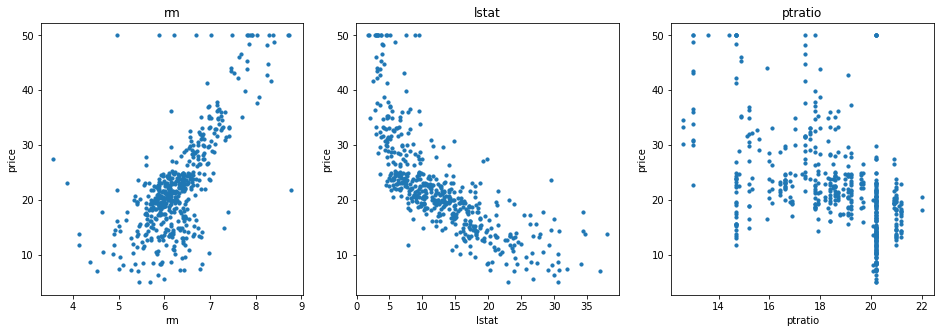

In [30]:
plt.figure(figsize=(16,5))
for i, col in enumerate(X.columns):
    plt.subplot(1,3,i+1)
    plt.scatter(df[col], y, s=10)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('price')

In [6]:
# Your observations here 
# Positive correlation between rm and price, negative between lstat and price, no clear
# correlation between ptratio and price

## Create Evaluation Metrics

- Create a function `performance(true, predicted)` to calculate and return the r-squared score and MSE for two equal sized arrays showing true and predicted values
- Test the function with given data 

In [31]:
# Evaluation Metrics
# Import metrics

def performance(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    r_squ = metrics.r2_score(y_true, y_predict)
    mse = metrics.mean_squared_error(y_true, y_predict)
    return r_squ, mse

# Calculate the performance - TEST
score = performance([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
score

# [0.9228556485355649, 0.4719999999999998]

(0.9228556485355649, 0.4719999999999998)

## Supervised Training 
- For supervised learning, split the `features` and `target` datasets into training/test data (80/20). 
- For reproducibility, use `random_state=42`

In [32]:
# Your code here 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Grow a Vanilla Regression Tree

- Run a baseline model for later comparison using the datasets created above
- Generate predictions for test dataset and calculate the performance measures using the function created above.
- Use `random_state=45` for tree instance
- Record your observations

In [36]:
tree_reg = DecisionTreeRegressor(random_state=45)
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)

In [37]:
performance(y_test, y_pred)

(0.47097115950374013, 38.795686274509805)

In [18]:
# Your code here 

# (0.4712438851035674, 38.7756862745098)  - R2, MSE

(0.47097115950374013, 38.795686274509805)

In [25]:
# Your observations here 
# Not a great r squared - explains less than half the variance. Probably overfitting and needs
# some tuning.

## Hyperparameter Tuning 

- Find the best tree depth for a depth range: 1-30
- Run the regressor repeatedly in a for loop for each depth value. 
- Use `random_state=45` for reproducibility
- Calculate MSE and r-squared for each run 
- Plot both performance measures, for all runs.
- Comment on the output 

In [49]:
mses = []
r_squs = []
for i in range(1,31):
    tree_reg = DecisionTreeRegressor(random_state=45, max_depth = i)
    tree_reg.fit(X_train, y_train)
    y_pred = tree_reg.predict(X_test)
    r_squ, mse = performance(y_test, y_pred)
    mses.append(mse)
    r_squs.append(r_squ)

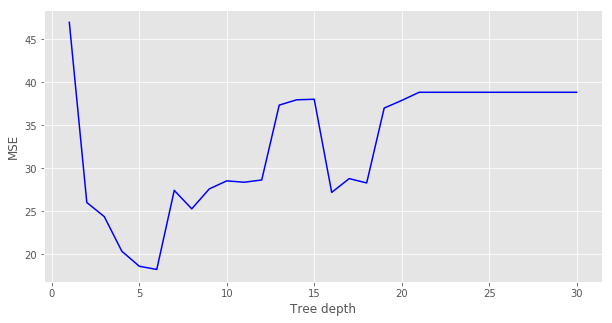

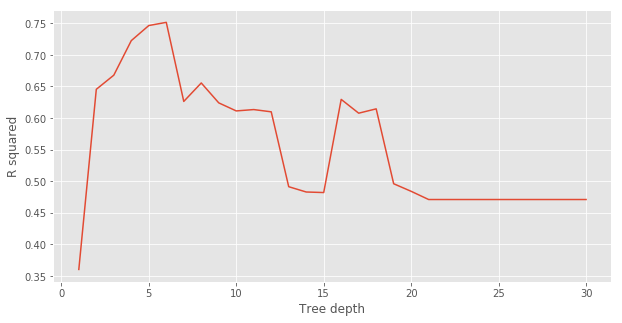

In [50]:
plt.figure(figsize=(10,5))
plt.plot(list(range(1,31)), mses, color='blue')
plt.xlabel('Tree depth')
plt.ylabel('MSE')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(list(range(1,31)), r_squs)
plt.xlabel('Tree depth')
plt.ylabel('R squared')
plt.show()

In [ ]:
# Your observations here 
# R squared increases and MSE decreases for tree depths up to 6 layers, then gets worse.

## More Hyperparameter Tuning 

- Repeat the above process for `min_samples_split` parameter

- Use a a range of values from 2-10 for this parameter 
- Use `random_state=45` for reproducibility
- Visualize the output and comment on results as above

In [51]:
mses = []
r_squs = []
for i in range(2,10):
    tree_reg = DecisionTreeRegressor(random_state=45, min_samples_split = i)
    tree_reg.fit(X_train, y_train)
    y_pred = tree_reg.predict(X_test)
    r_squ, mse = performance(y_test, y_pred)
    mses.append(mse)
    r_squs.append(r_squ)

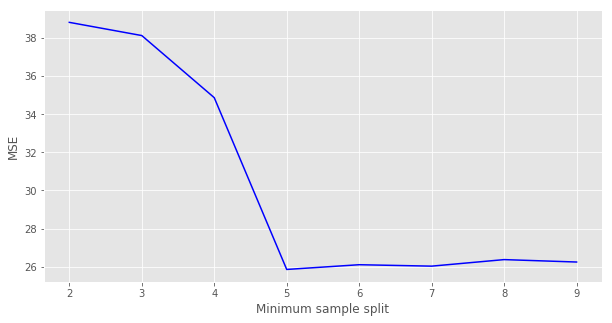

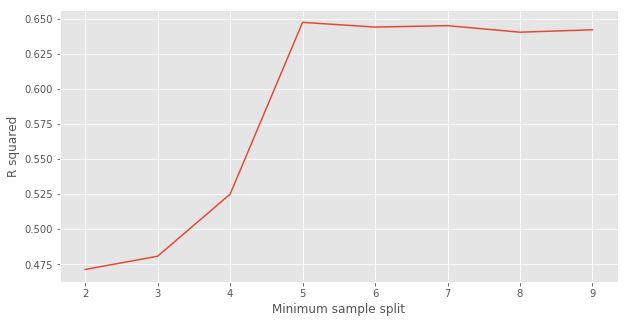

In [55]:
plt.figure(figsize=(10,5))
plt.plot(list(range(2,10)), mses, color='blue')
plt.xlabel('Minimum sample split')
plt.ylabel('MSE')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(list(range(2,10)), r_squs)
plt.xlabel('Minimum sample split')
plt.ylabel('R squared')
plt.show()

In [34]:
# Your observations here 
# Optimum is minimum sample split of at least 5 - choose 6 as better than border values.

# Run the "Optimized" Model 

- Use the best values for max_depth and min_samples_split found in previous runs and run an optimized model with these values. 
- Calculate the performance and comment on the output 

In [56]:
tree_reg = DecisionTreeRegressor(random_state=45, max_depth = 6, min_samples_split = 6)
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)

In [57]:
performance(y_test, y_pred)

(0.7510017608643338, 18.259982876077185)

In [36]:
# Your observation
# This has increased the r squared up to 0.75, and decreased the MSE to 18.

## Visualize the tree
- Visualize the trained model as we did in previous sections
- Show the labels for each variable being split in a node
- Interpret the tree

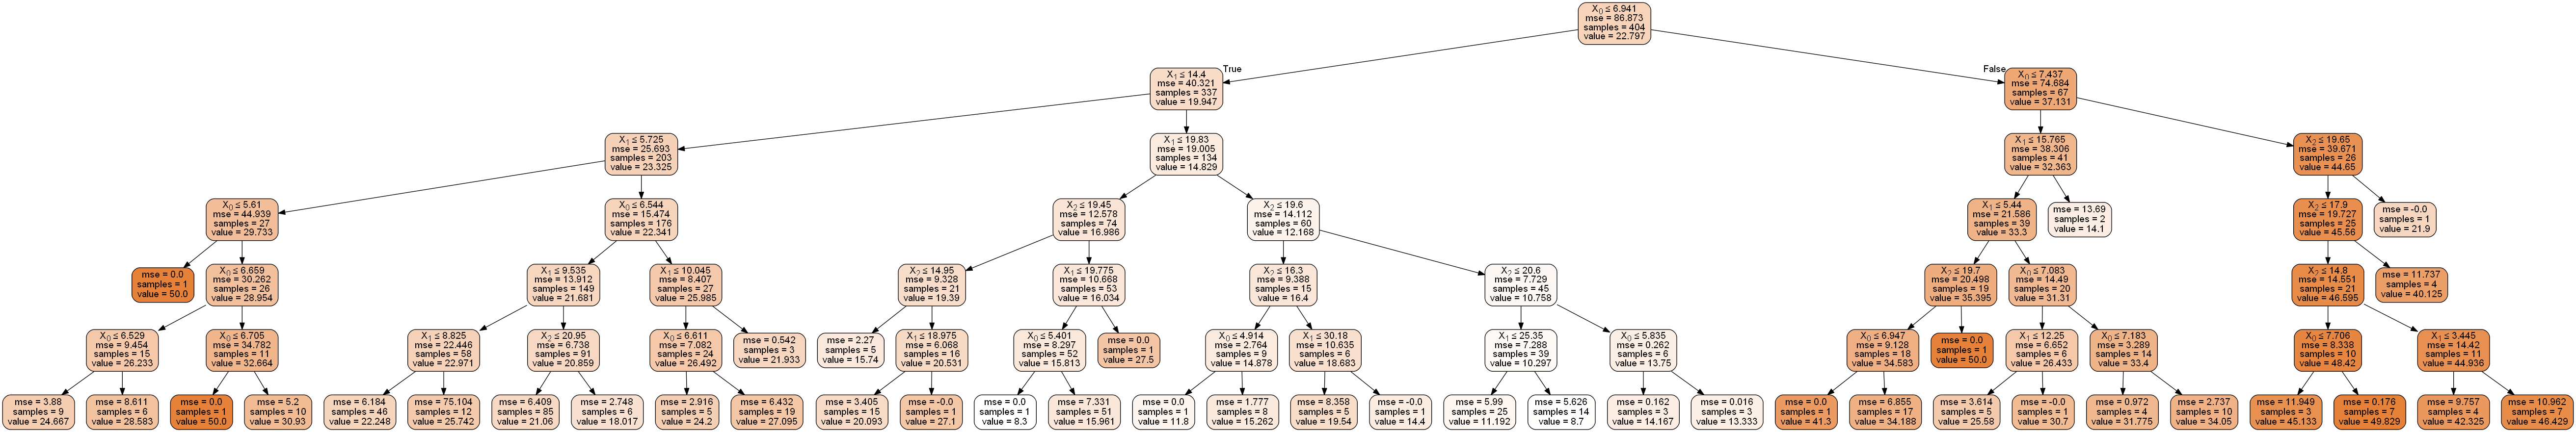

In [58]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(tree_reg, out_file=dot_data, filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [39]:
#Your observations here 

## Level Up - Optional 

- How about bringing in some more features from the original dataset which may be good predictors
- Also , Tune more more hyper parameters like max-features to find the optimal model 


## Summary 

In this lab, we looked at applying a decision tree based regression analysis on the Boston Housing Dataset. We saw how to train various models to find the optimal values for pruning and limiting the growth of the trees. We also looked at how to extract some rules from visualizing trees , that might be used for decision making later. In the next section we shall look at running "Grid Searches" for identifying the best model while tuning all required hyper-parameters - at once. 